# Python solution 
to validate bank submission and perform auto-data correction before feeding into the consensus check

# Overrall design:
    
    step 1 - using the raw submission file to produce some useful data insights 
    step 2 (technical step) - create all validation functions first and will save them all in a module for use later
    Step 3 - using all the functions from step 2 to perform the check on the orignial submission and create all necessary new columns with check result, and produce a report for the validation reports (without any data manipulation), including duplication check
    step 4 - perform auto data correction with the orignal value included as well (for audit purpose)
    step 5 - produce a final submission file with all corrected data for consensus run
    
    is any ML model any useful here?

# things to include in the solution:
    1. original data with their check results (no data manipulation)
    2. manipulated data
    3. counts on all error rows v original submission rows
    4. duplication check (after the individual data point validation)
    

# Step 1 - basic EDA on bank submission 

- using CS submission on Nov 2021 as an example here

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import datetime
import ccy
from fuzzywuzzy import process


/Users/lchen/opt/anaconda3/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#from submission_validation_module import *
from mymodule import *

In [3]:
#import sys, importlib
#importlib.reload(sys.modules['mymodule'])
#from mymodule import submission_mid_fwrd_points_cal_tolerance_check

In [66]:
#!pip install voila so others can use the code without having
!jupyter serverextension enable voila-sys-prefix

Enabling: voila-sys-prefix
- Writing config: /Users/lchen/.jupyter
    - Validating...
Error loading server extension voila-sys-prefix
      X is voila-sys-prefix importable?


# set file path

In [4]:
path = '/Users/lchen/Desktop/Titanium/python_scripts/LC_folder/CS_Forwards_Nov.csv'

# Open submission file

In [5]:
cs_nov = pd.read_csv(path)

In [6]:
cs_nov.head()

,submission_date,submission_client,submission_asset,submission_service,submission_snap_time,submission_curr_1,submission_curr_2,submission_onshore_offshore_curr_1,submission_onshore_offshore_curr_2,submission_instrument_type,submission_tenor,submission_fwrd_conversion_factor,submission_value_source,submission_value_source_ref_id,submission_spot_reference_price,submission_mid_fwrd_outright,submission_mid_fwrd_points
0,11/30/21,Credit Suisse,Foreign Exchange,Vanilla,London 4 PM,AUD,CAD,NaN,NaN,Spot Price,Spot,NaN,NaN,NaN,0.913745,NaN,0.913745
1,11/30/21,Credit Suisse,Foreign Exchange,Vanilla,London 4 PM,AUD,CAD,NaN,NaN,Forward,ON,10000.0,NaN,NaN,0.913745,0.913750,0.048486
2,11/30/21,Credit Suisse,Foreign Exchange,Vanilla,London 4 PM,AUD,CAD,NaN,NaN,Forward,TN,10000.0,NaN,NaN,0.913745,0.913750,0.048486
3,11/30/21,Credit Suisse,Foreign Exchange,Vanilla,London 4 PM,AUD,CAD,NaN,NaN,Forward,SpotNext,10000.0,NaN,NaN,0.913745,0.913750,0.048486
4,11/30/21,Credit Suisse,Foreign Exchange,Vanilla,London 4 PM,AUD,CAD,NaN,NaN,Forward,1W,10000.0,NaN,NaN,0.913745,0.913776,0.309370


In [7]:
print (f'There are {cs_nov.shape[0]} rows in the submission \nThere are {cs_nov.shape[1]} columns in the submission')

There are 3313 rows in the submission 
There are 17 columns in the submission


In [8]:
spot_price_null = cs_nov['submission_spot_reference_price'].isna().sum()
fwrd_outright_null = cs_nov['submission_mid_fwrd_outright'].isna().sum()
fwrd_points_null = cs_nov['submission_mid_fwrd_points'].isna().sum()
print(f'There are {spot_price_null} rows with no spot price provided \nThere are {fwrd_outright_null} rows with no fwrd points provided\nThere are {fwrd_points_null} rows with no fwrd points provided')

There are 0 rows with no spot price provided 
There are 149 rows with no fwrd points provided
There are 0 rows with no fwrd points provided


# Step 1 (optional) - visualisation on submission points

if needed, need to change the code to accommodate all currency paires

In [9]:
# use one currency pair as example, group by this pair first
cols = ['submission_curr_1','submission_curr_2']
cs_nov['currency_pair'] = cs_nov[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [10]:
aud_cad = cs_nov.loc[cs_nov['currency_pair'] == 'AUD_CAD']

In [11]:
# using melt to pull only outright and points columns before plotting them against each other
aud_cad_small = aud_cad[['submission_tenor','submission_mid_fwrd_outright','submission_mid_fwrd_points' ]]
aud_cad_plot = aud_cad_small.melt('submission_tenor', var_name='cols', value_name='rates')

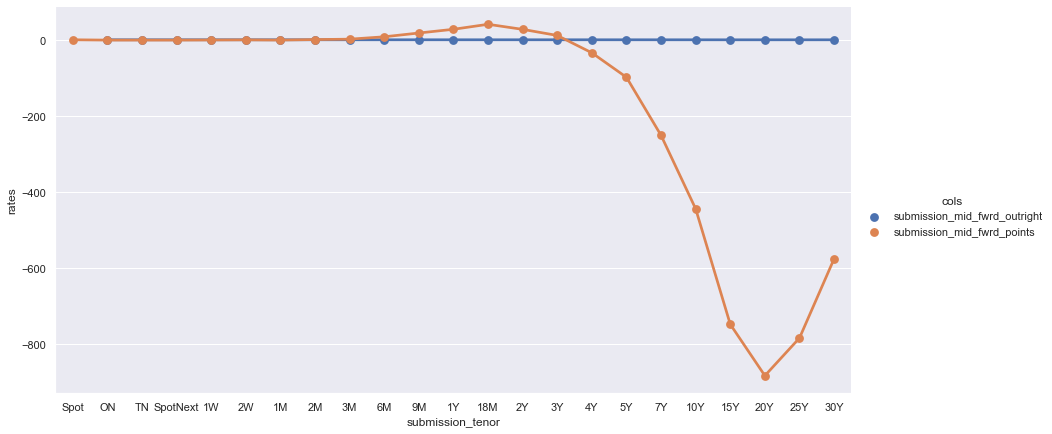

In [12]:
sns.set(rc={'figure.figsize':(25,30)})
graph1 = sns.catplot(x="submission_tenor", y="rates", hue='cols', data=aud_cad_plot, kind='point',height=6, aspect=2)

# Step 2.1 - prepare the files for validaiton checks

In [13]:
# create unique key column
cols_1 = ['submission_curr_1','submission_curr_2','submission_onshore_offshore_curr_1', 'submission_onshore_offshore_curr_2','submission_instrument_type','submission_tenor']
cs_nov['unique_key'] = cs_nov[cols_1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# Step 2.2 - all validaiton checks in a seperate module

# Step 3.1 - validation check error report (client sharable)

In [14]:
data = {'Check_name':['date_format_check','client_name_check','submission_asset_check','service_check_result','snaptime_check_result','curr1_check_error_count','curr2_check_error_count','currency_pair_check_result','instrument_type_match_lowscore_count','tenor_match_lowscore_count','fwrd_conversion_factor_check_result','value_source_match_lowscore_count','onoffshore_curr1_match_score_result','onoffshore_curr2_match_score_result','onoffshore_curr1_validity_error_count','onoffshore_curr2_validity_error_count','spot_reference_price_nullcheck_error_count','mid_fwrd_outright_nullcheck_error_count','mid_fwrd_points_tolerance_error_count'],'Error_count':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]}
validation_summary = pd.DataFrame(data)

In [15]:
validation_summary

,Check_name,Error_count
0,date_format_check,0
1,client_name_check,0
2,submission_asset_check,0
3,service_check_result,0
4,snaptime_check_result,0
5,curr1_check_error_count,0
6,curr2_check_error_count,0
7,currency_pair_check_result,0
8,instrument_type_match_lowscore_count,0
9,tenor_match_lowscore_count,0


# Step 3.2 - apply checks to submission file
and add check result to the error report created above

# apply data format check

In [16]:
# apply date format check

cs_nov['date_format_check_result'] = cs_nov['submission_client'].apply(lambda x: date_format_check(cs_nov['submission_date']))

In [17]:
# calculate the error count on the result column
date_error_count = len(cs_nov) - cs_nov.date_format_check_result.value_counts().PASSED
date_error_count

0

# apply submission_client check

In [18]:
cs_nov['client_name_check_result'] = cs_nov['submission_client'].map(client_name_check)

In [19]:
client_name_error_count = len(cs_nov) - cs_nov.client_name_check_result.value_counts().PASSED
client_name_error_count

0

# apply submission_asset_check

In [20]:
cs_nov['asset_check_result'] = cs_nov['submission_asset'].map(submission_asset_check)

In [21]:
cs_nov.columns

Index(['submission_date', 'submission_client', 'submission_asset',
       'submission_service', 'submission_snap_time', 'submission_curr_1',
       'submission_curr_2', 'submission_onshore_offshore_curr_1',
       'submission_onshore_offshore_curr_2', 'submission_instrument_type',
       'submission_tenor', 'submission_fwrd_conversion_factor',
       'submission_value_source', 'submission_value_source_ref_id',
       'submission_spot_reference_price', 'submission_mid_fwrd_outright',
       'submission_mid_fwrd_points', 'currency_pair', 'unique_key',
       'date_format_check_result', 'client_name_check_result',
       'asset_check_result'],
      dtype='object')

In [22]:
asset_check_error_count =len(cs_nov)-len(cs_nov[~cs_nov.asset_check_result.str.startswith('Invalid')])
asset_check_error_count

0

# apply submission_service check

In [23]:
cs_nov['service_check_result'] = cs_nov['submission_service'].map(submission_service_check)

In [24]:
service_check_error_count =len(cs_nov)-len(cs_nov[~cs_nov.service_check_result.str.startswith('Invalid')])
service_check_error_count

0

# apply submission_snap_time check

In [25]:
cs_nov['snaptime_check_result'] = cs_nov['submission_snap_time'].map(submission_snaptime_check)

In [26]:
snaptime_check_error_count =len(cs_nov)-len(cs_nov[~cs_nov.snaptime_check_result.str.startswith('Invalid')])
snaptime_check_error_count

0

# apply submission_curr check

In [27]:
cs_nov['curr1_check_result'] = cs_nov['submission_curr_1'].map(submission_curr_check)
cs_nov['curr2_check_result'] = cs_nov['submission_curr_2'].map(submission_curr_check)

In [28]:
curr1_check_error_count =len(cs_nov)-len(cs_nov[~cs_nov.curr1_check_result.str.startswith('Invalid')])
curr2_check_error_count =len(cs_nov)-len(cs_nov[~cs_nov.curr2_check_result.str.startswith('Invalid')])
print(f'{curr1_check_error_count} \n{curr2_check_error_count}')

0 
0


In [29]:
#test1 = cs_nov[cs_nov.curr1_check_result.str.startswith('Invalid')]
#test2 = cs_nov[cs_nov.curr2_check_result.str.startswith('Invalid')]
#print(test1['submission_curr_1'].value_counts())
#print(test2['submission_curr_2'].value_counts())

# apply Validate against reference data for valid currency

In [30]:
final =[]
for curr1, curr2 in zip(cs_nov.submission_curr_1,cs_nov.submission_curr_2):
    final.append(valid_currency_pair_check(curr1, curr2))
cs_nov['currency_pair_check_result'] = final
currency_pair_check_error_count =len(cs_nov)-len(cs_nov[~cs_nov.currency_pair_check_result.str.startswith('Invalid')])

In [31]:
currency_pair_check_error_count

3267

# apply submission_instrument_type check & auto-correction

In [32]:
cs_nov['instrument_type_check_result'] = cs_nov['submission_instrument_type'].map(submission_instrument_type_match)
cs_nov['instrument_type_match_score'] = cs_nov['submission_instrument_type'].map(submission_instrument_type_match_score)

In [33]:
instrument_type_match_lowscore_count =len(cs_nov[cs_nov['instrument_type_match_score']<= 30])
print(instrument_type_match_lowscore_count)

0


# apply submission_tenor check

In [34]:
cs_nov['tenor_check_result'] = cs_nov['submission_tenor'].map(submission_tenor_check)
cs_nov['tenor_match_score'] = cs_nov['submission_tenor'].map(submission_tenor_match_score_check)

In [35]:
tenor_match_lowscore_count =len(cs_nov[cs_nov['tenor_match_score']<= 30])
print(tenor_match_lowscore_count)

0


# apply submission_fwrd_conversion_factor check

In [36]:
cs_nov['fwrd_conversion_factor_check_result'] = cs_nov['submission_fwrd_conversion_factor'].map(submission_fwrd_conversion_factor_double_check)

In [37]:
conversion_factor_check_error_count =len(cs_nov)-len(cs_nov[~cs_nov.fwrd_conversion_factor_check_result.str.startswith('Invalid')])
print(conversion_factor_check_error_count)

0


# apply submission_value_source check

codes need to be revisited to make more efficient!

In [38]:
value_source_list = cs_nov['submission_value_source']
value_source_match_score = []
for val in value_source_list:
    if val !=val:
        value_source_match_score.append('PASSED')
    else:
        value_source_match_score.append(submission_value_source_check(val))


In [39]:
len(value_source_match_score)

3313

In [40]:
cs_nov['value_source_check_result'] = np.array(value_source_match_score)

In [41]:
value_source_match_score_result = []
for val in value_source_list:
    if val !=val:
        value_source_match_score_result.append(int(100))
    else:
        value_source_match_score_result.append(submission_onshore_offshore_match_score(val))

In [42]:
cs_nov['value_source_match_score'] = np.array(value_source_match_score_result)

In [43]:
value_source_match_lowscore_count =len(cs_nov[cs_nov['value_source_match_score']<= 30])
print(value_source_match_lowscore_count)

0


# apply submission_onshore_offshore_curr check on both curr1 and curr2

codes need to be revisited to make more efficient!

In [44]:
onoffshore_list1 = cs_nov['submission_onshore_offshore_curr_1']
onoffshore_list2 = cs_nov['submission_onshore_offshore_curr_2']
submission_curr_list1 = cs_nov['submission_curr_1']
submission_curr_list2 = cs_nov['submission_curr_2']

In [45]:
onoffshore_curr1_check_result = []
onoffshore_curr2_check_result = []

for val1 in onoffshore_list1:
    if val1 !=val1:
        onoffshore_curr1_check_result.append('PASSED')
    else:
        onoffshore_curr1_check_result.append(submission_onshore_offshore_check(val1))
        
for val2 in onoffshore_list2:
    if val2 !=val2:
        onoffshore_curr2_check_result.append('PASSED')
    else:
        onoffshore_curr2_check_result.append(submission_onshore_offshore_check(val2))

In [46]:
onoffshore_curr1_match_score_result = []
onoffshore_curr2_match_score_result = []

for val1 in onoffshore_list1:
    if val1 !=val1:
        onoffshore_curr1_match_score_result.append(int(100))
    else:
        onoffshore_curr1_match_score_result.append(submission_onshore_offshore_match_score(val1))

for val2 in onoffshore_list2:
    if val2 !=val2:
        onoffshore_curr2_match_score_result.append(int(100))
    else:
        onoffshore_curr2_match_score_result.append(submission_onshore_offshore_match_score(val2))

In [47]:
cs_nov['onoffshore_curr1_check_result'] = np.array(onoffshore_curr1_check_result)
cs_nov['onoffshore_curr1_match_score_result'] = np.array(onoffshore_curr1_match_score_result)

In [48]:
cs_nov['onoffshore_curr2_check_result'] = np.array(onoffshore_curr2_check_result)
cs_nov['onoffshore_curr2_match_score_result'] = np.array(onoffshore_curr2_match_score_result)

In [49]:
onoffshore_curr1_match_lowscore_count =len(cs_nov[cs_nov['onoffshore_curr1_match_score_result']<= 30])
onoffshore_curr2_match_lowscore_count =len(cs_nov[cs_nov['onoffshore_curr2_match_score_result']<= 30])
print(f'{onoffshore_curr1_match_lowscore_count} \n{onoffshore_curr2_match_lowscore_count}')                                                

0 
0


# apply submission_curr code and onoffshore flag validity check

In [50]:
onoffshore_curr1_validity_check =[]
onoffshore_curr2_validity_check =[]

for curr1, flag1 in zip(submission_curr_list1,onoffshore_list1):
    onoffshore_curr1_validity_check.append(submission_onshore_offshore_curr_check(curr1,flag1))

for curr2, flag2 in zip(submission_curr_list2,onoffshore_list2):
    onoffshore_curr2_validity_check.append(submission_onshore_offshore_curr_check(curr2,flag2))

In [51]:
cs_nov['onoffshore_curr1_validity_check_result'] = np.array(onoffshore_curr1_validity_check)
cs_nov['onoffshore_curr2_validity_check_result'] = np.array(onoffshore_curr2_validity_check)

In [52]:
onoffshore_curr1_validity_error_count =len(cs_nov)-len(cs_nov[~cs_nov.onoffshore_curr1_validity_check_result.str.startswith('Inconsistent')])
onoffshore_curr2_validity_error_count =len(cs_nov)-len(cs_nov[~cs_nov.onoffshore_curr2_validity_check_result.str.startswith('Inconsistent')])
print(f'{onoffshore_curr1_validity_error_count} \n{onoffshore_curr2_validity_error_count}')

110 
264


# apply submission_spot_reference_price check

In [53]:
cs_nov['spot_reference_price_nullcheck_result'] = cs_nov['submission_spot_reference_price'].map(submission_spot_reference_price_check)

In [54]:
spot_reference_price_nullcheck_error_count =len(cs_nov)-len(cs_nov[~cs_nov.spot_reference_price_nullcheck_result.str.startswith('Invalid')])
print(spot_reference_price_nullcheck_error_count)

0


# apply submission_spot_reference_price auto-fill - TO BE COMPLETED

# apply submission_mid_fwrd_outright check

In [55]:
cs_nov['mid_fwrd_outright_nullcheck_result'] = cs_nov['submission_mid_fwrd_outright'].map(submission_mid_fwrd_outright_check)

In [56]:
mid_fwrd_outright_nullcheck_error_count =len(cs_nov)-len(cs_nov[~cs_nov.mid_fwrd_outright_nullcheck_result.str.startswith('Invalid')])
print(mid_fwrd_outright_nullcheck_error_count)

149


# apply submission_mid_fwrd_points_tolerance check

In [57]:
cs_nov['mid_fwrd_points_calculated'] = (cs_nov['submission_mid_fwrd_outright']-cs_nov['submission_spot_reference_price'])*cs_nov['submission_fwrd_conversion_factor']

In [58]:
cs_nov['mid_fwrd_points_cal_diff'] = (cs_nov['submission_mid_fwrd_points']-cs_nov['mid_fwrd_points_calculated'])/cs_nov['submission_mid_fwrd_points']

In [59]:
cs_nov['mid_fwrd_points_tolerance_check_result'] = cs_nov['mid_fwrd_points_cal_diff'].map(submission_mid_fwrd_points_cal_tolerance_check)

In [60]:
mid_fwrd_points_tolerance_error_count =len(cs_nov)-len(cs_nov[~cs_nov.mid_fwrd_points_tolerance_check_result.str.startswith('Invalid')])
print(mid_fwrd_points_tolerance_error_count)

0


# Add all check results to the summary table

In [61]:
validation_summary.loc[0, 'Error_count'] = date_error_count
validation_summary.loc[1, 'Error_count'] = client_name_error_count
validation_summary.loc[2, 'Error_count'] = asset_check_error_count
validation_summary.loc[3, 'Error_count'] = service_check_error_count
validation_summary.loc[4, 'Error_count'] = snaptime_check_error_count
validation_summary.loc[5, 'Error_count'] = curr1_check_error_count
validation_summary.loc[6, 'Error_count'] = curr2_check_error_count
validation_summary.loc[7, 'Error_count'] = currency_pair_check_error_count
validation_summary.loc[8, 'Error_count'] = instrument_type_match_lowscore_count
validation_summary.loc[9, 'Error_count'] = tenor_match_lowscore_count
validation_summary.loc[10, 'Error_count'] = conversion_factor_check_error_count
validation_summary.loc[11, 'Error_count'] = value_source_match_lowscore_count
validation_summary.loc[12, 'Error_count'] = onoffshore_curr1_match_lowscore_count
validation_summary.loc[13, 'Error_count'] = onoffshore_curr2_match_lowscore_count
validation_summary.loc[14, 'Error_count'] = onoffshore_curr1_validity_error_count
validation_summary.loc[15, 'Error_count'] = onoffshore_curr2_validity_error_count
validation_summary.loc[16, 'Error_count'] = spot_reference_price_nullcheck_error_count
validation_summary.loc[17, 'Error_count'] = mid_fwrd_outright_nullcheck_error_count

In [62]:
validation_summary

,Check_name,Error_count
0,date_format_check,0
1,client_name_check,0
2,submission_asset_check,0
3,service_check_result,0
4,snaptime_check_result,0
5,curr1_check_error_count,0
6,curr2_check_error_count,0
7,currency_pair_check_result,3267
8,instrument_type_match_lowscore_count,0
9,tenor_match_lowscore_count,0


# save validation summary report to a csv file (into the same location)

In [64]:
validation_summary.to_csv('validation_summary_cs_Nov.csv', index=False)

# save submission check file with all check results details to a csv file (into the same location)

In [65]:
cs_nov.to_csv('cs_Nov_submission_dq_report.csv', index=False)